<a href="https://colab.research.google.com/github/HARSHAZGREAT/DBtask2/blob/main/image_segment_db.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.youtube.com/watch?v=l1dhyw-EjSw
https://www.youtube.com/watch?v=XNf1ATR9OSk


In [ ]:
import os
import glob
import cv2
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from google.colab import drive
import json
from skimage.measure import label, regionprops
from sklearn.metrics import jaccard_score
import torch
from torch.utils.data import DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.transforms import functional as F
from torchvision.datasets.folder import default_loader
from torchvision.transforms import ToTensor
from torchvision.transforms import Compose
from torchvision.transforms import Normalize
from torchvision.transforms import Resize

In [ ]:
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
image_names = glob.glob("/content/gdrive/MyDrive/ML datasets/trafficsigns/sign_dataset/train/train/*.jpg")
image_names.sort()

num_images_to_load = 10

image_path = [i for i in image_names[:num_images_to_load]]
selected_image_names = image_names[:num_images_to_load]

images = [cv2.imread(image, 0) for image in selected_image_names]
image_dataset = np.array(images)

print("Loaded ", len(image_dataset)," images")

Loaded  10  images


<ipython-input-12-36685b62cdbb>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  image_dataset = np.array(images)


In [ ]:
print(image_dataset.shape)

(10,)


In [ ]:
mask_names = glob.glob("/content/gdrive/MyDrive/ML datasets/trafficsigns/sign_dataset/train/train/*.json")
mask_names.sort()

num_images_to_load = 10

mask_path = [i for i in mask_names[:num_images_to_load]]
print(mask_path)

['/content/gdrive/MyDrive/ML datasets/trafficsigns/sign_dataset/train/train/1.jpg_coco.json', '/content/gdrive/MyDrive/ML datasets/trafficsigns/sign_dataset/train/train/10.jpg_coco.json', '/content/gdrive/MyDrive/ML datasets/trafficsigns/sign_dataset/train/train/100.jpg_coco.json', '/content/gdrive/MyDrive/ML datasets/trafficsigns/sign_dataset/train/train/1000.jpg_coco.json', '/content/gdrive/MyDrive/ML datasets/trafficsigns/sign_dataset/train/train/1001.jpg_coco.json', '/content/gdrive/MyDrive/ML datasets/trafficsigns/sign_dataset/train/train/1002.jpg_coco.json', '/content/gdrive/MyDrive/ML datasets/trafficsigns/sign_dataset/train/train/1003.jpg_coco.json', '/content/gdrive/MyDrive/ML datasets/trafficsigns/sign_dataset/train/train/1004.jpg_coco.json', '/content/gdrive/MyDrive/ML datasets/trafficsigns/sign_dataset/train/train/1005.jpg_coco.json', '/content/gdrive/MyDrive/ML datasets/trafficsigns/sign_dataset/train/train/1006.jpg_coco.json']


In [ ]:
masks_dataset = []
count = 0
for i in mask_path:
  with open(i, 'r') as json_file:
    json_data = json.load(json_file)
  masks_dataset.append(json_data)
  count += 1
  if count < 10:
    print(np.array(json_data['masks']).shape)
  else:
    break

(56, 56, 8)
(56, 56, 0)
(56, 56, 18)
(56, 56, 6)
(56, 56, 12)
(56, 56, 7)
(56, 56, 9)
(56, 56, 8)
(56, 56, 10)


In [ ]:
print(masks_dataset[0].keys())

dict_keys(['masks', 'rois', 'scores', 'class_ids', 'bbox'])


(56, 56, 6)
6
1


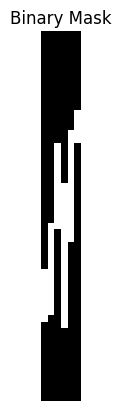

2


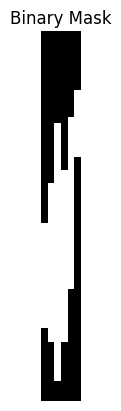

3


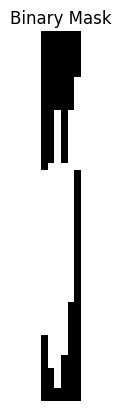

4


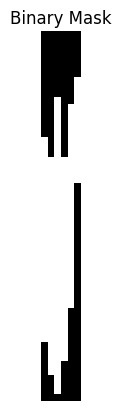

5


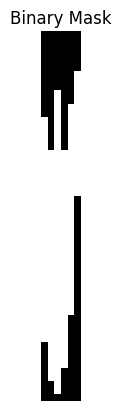

6


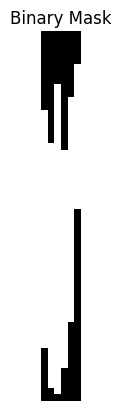

In [ ]:
mask = masks_dataset[3]['masks']
mask = np.array(mask)
print(mask.shape)

x = mask.shape[2]
print(x)

for i in range(x):
  print(i+1)
  plt.imshow(mask[i], cmap='gray', interpolation='nearest')
  plt.title('Binary Mask')
  plt.axis('off')
  plt.show()

In [ ]:
print(type(image_path[3]))

<class 'str'>


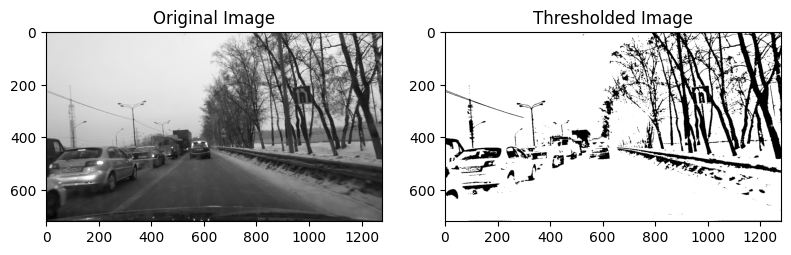

In [ ]:
for i in range(1):
  image = image_dataset[i]

  block_size = 151
  c = 25
  threshold_image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, block_size, c)
  labeled_image = label(threshold_image)
  regions = regionprops(labeled_image)
  mask = np.zeros_like(threshold_image, dtype=bool)

  for region in regions:
    bbox = region.bbox
    mask[bbox[0]:bbox[2], bbox[1]:bbox[3]] = True

  masked_image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
  masked_image[mask] = [0, 255, 0]

  bounding_boxes = [region.bbox for region in regions]

  plt.figure(figsize=(12, 6))

  plt.subplot(131)
  plt.imshow(image, cmap='gray')
  plt.title('Original Image')

  plt.subplot(132)
  plt.imshow(threshold_image, cmap='gray')
  plt.title('Thresholded Image')

  plt.tight_layout()
  plt.show()

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_path, mask_path, transform=None):
        self.image_path = image_path
        self.mask_path = mask_path
        self.transform = transform

    def __len__(self):
        return len(self.image_path)

    def __getitem__(self, idx):
        image = default_loader(self.image_path[idx])
        mask = np.load(self.mask_path[idx])
        mask = np.where(mask > 0, 1, 0)

        if self.transform:
            image = self.transform(image)

        return image, mask


transform = Compose([Resize((256, 256)), ToTensor(), Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

batch_size = 2
dataset = CustomDataset(image_path, mask_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = fasterrcnn_resnet50_fpn(pretrained=True)

optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for images, masks in dataloader:
        optimizer.zero_grad()
        masks = masks.to(dtype=torch.float32)
        targets = [{'masks': mask} for mask in masks]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()
    lr_scheduler.step()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {losses.item()}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:05<00:00, 28.1MB/s]


ValueError: ignored